# GPT-2 Fine-Tuning Tutorial with PyTorch & Huggingface in Colab




References:
- 
- 

# Setup

In [1]:
%pip install -q transformers
%pip install -q seaborn
%pip install -q nltk

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
!ls

Sinas-Distil-GPT2.ipynb  WIP-GPT2-v2.ipynb  instance_type.png
WIP-Distil-GPT2.ipynb	 checkpoints	    quick_start_pytorch.ipynb


In [3]:
import os
import json
import time
import datetime

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
#% matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Create Training Set

In [4]:
wikihow_path = '/datasets/wikihow-small-json'
#wikihow_file = 'wikihowAll.csv' # Large dataset
wikihow_file = 'wikihow_dataset.json'
wikihow_open = os.path.join(wikihow_path, wikihow_file)


In [5]:
# Read file
with open(wikihow_open) as json_file:
    data = json.load(json_file)

# load into a data frame
df = pd.DataFrame.from_records(data["data"])
df.shape

(1878, 3)

In [6]:
# Clean Data
df['task'] = df['task'].astype(str)
df['solution'] = df['solution'].astype(str)
df['summary'] = df['summary'].astype(str)

# drop NA's
df = df.dropna()
df.head()

,task,solution,summary
0,How to Attract Birds to Your Garden,"In order to decide on suitable feeders, you sh...",Choose appropriate feeders.\nProvide a variety...
1,How to Grow Biennial Vegetables,Biennials should be planted in the late spring...,Wait to plant until after the final frost to p...
2,How to Sew a Blazer,Most patterns tell you the difficulty level fo...,Download a pattern or buy a printed pattern fr...
3,How to Sew Patches,It is important to make sure that your patch m...,Get a patch that matches the fabric.\nSnip awa...
4,How to Pickle Onions,Red onions go great for this recipe; with thei...,"Halve, peel, and slice the onion.\nHeat some w..."


In [7]:
# Add marks for original promp and repsonse marks
df['task'] = '[WP]' + df['task'] # + '?'
df['solution'] = '\n[RESPONSE]' + df['solution']
df.head()

,task,solution,summary
0,[WP]How to Attract Birds to Your Garden,\n[RESPONSE]In order to decide on suitable fee...,Choose appropriate feeders.\nProvide a variety...
1,[WP]How to Grow Biennial Vegetables,\n[RESPONSE]Biennials should be planted in the...,Wait to plant until after the final frost to p...
2,[WP]How to Sew a Blazer,\n[RESPONSE]Most patterns tell you the difficu...,Download a pattern or buy a printed pattern fr...
3,[WP]How to Sew Patches,\n[RESPONSE]It is important to make sure that ...,Get a patch that matches the fabric.\nSnip awa...
4,[WP]How to Pickle Onions,\n[RESPONSE]Red onions go great for this recip...,"Halve, peel, and slice the onion.\nHeat some w..."


In [8]:
# merge into one
howtos = df["task"] + df["solution"] # \n vs ' ' ???
#howtos = howtos.str.replace('"', '').str.replace('\n,\n', '').str.replace('``', '').str.replace(',,', ',')

howtos.head()



0    [WP]How to Attract Birds to Your Garden\n[RESP...
1    [WP]How to Grow Biennial Vegetables\n[RESPONSE...
2    [WP]How to Sew a Blazer\n[RESPONSE]Most patter...
3    [WP]How to Sew Patches\n[RESPONSE]It is import...
4    [WP]How to Pickle Onions\n[RESPONSE]Red onions...
dtype: object

In [9]:
small_sample = howtos.sample(300)

In [10]:
replace_dict = {'[WP]': '!'}
#small_sample = pd.Series(small_sample)
small_sample.str.replace('"', '').str.replace('\n,\n', '').str.replace('``', '').str.replace(',,', ',')


1424    [WP]How to Keep Weeds Out of Your Vegetable Ga...
207     [WP]How to Grow Catnip\n[RESPONSE]Local home a...
457     [WP]How to Grow Cinnamon\n[RESPONSE]Cinnamon t...
1713    [WP]How to Clean a Cuisinart Coffee Maker\n[RE...
632     [WP]How to Create a Bee%E2%80%90Friendly Garde...
                              ...                        
1796    [WP]How to Start a Sewing Machine\n[RESPONSE]T...
1271    [WP]How to Grow Fenugreek\n[RESPONSE]Before yo...
1140    [WP]How to Create a Photo Slideshow with Power...
931     [WP]How to Create Photo Albums on an iPad\n[RE...
637     [WP]How to Turn a Girl On\n[RESPONSE]Breath is...
Length: 300, dtype: object

In [11]:
def clean_text(text):
    #text = text.replace('\n','')
    text = text.replace('``', '')
    text = text.replace('"', '')
    text = text.replace("\n,\n", "").replace(".,", ".").replace('"', '').replace('\n','')
    text = text.replace(" ,", ",").replace(" .", ".").replace(" %", "%")
    text = text.replace(" - ", "-").replace(" : ", ":").replace(" / ", "/")
    text = text.replace("( ", "(").replace(" )", ")")
    #text = text.replace("`` ", "\"").replace(" ''", "\"")
    text = text.replace(" 's", "'s").replace("s ' ", "s' ")
    return text

check length

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

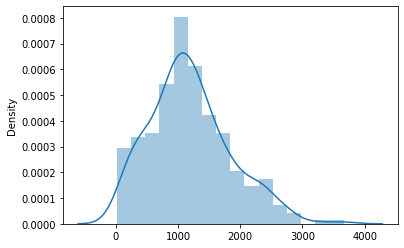

In [12]:
doc_lengths = []

for howto in howtos.sample(n=300):

    # get rough token count distribution
    tokens = nltk.word_tokenize(howto)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [13]:
# the max token length   
len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

0.7366666666666667

In [14]:
np.average(doc_lengths)

1189.71

# GPT2 Tokenizer

In [15]:
# NOTE: EMBEDDING SIZE NOT LARGE ENOUGH!!! -- SHOULD USE LARGER MODEL
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium


Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# PyTorch Datasets & Dataloaders


Testing I managed to run it in 4 using Paperspace PRO machines

In [16]:
batch_size = 4

In [17]:
def clean_text(text):
    text = text.replace('\n\n\n\n','\n').replace('\n\n\n','\n').replace('\n ','\n')
    text = text.replace('``', '').replace('.;', '.')
    text = text.replace('"', '').replace("\n,", "").replace("\n, ", "")
    text = text.replace("\n,\n", "").replace(".,", ".").replace('"', '').replace('\n;\n','')
    text = text.replace(" ,", ",").replace(" .", ".").replace(" %", "%")
    text = text.replace(" - ", "-").replace(" : ", ":").replace(" / ", "/")
    text = text.replace("( ", "(").replace(" )", ")")
    #text = text.replace("`` ", "\"").replace(" ''", "\"")
    text = text.replace(" 's", "'s").replace("s ' ", "s' ")
    return text
    
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=1024):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:
    
      text = txt #= clean_text(txt)
      encodings_dict = tokenizer('<|startoftext|>'+ text + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

In [18]:
dataset = GPT2Dataset(howtos, tokenizer, max_length=1024)

# Split into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

1,502 training samples
  376 validation samples


In [19]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Fine-tune

In [20]:
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

In [21]:
# some parameters I cooked up that work reasonably well

epochs = 3
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8
check_path = './checkpoints'



# this produces sample output every 100 steps
sample_every = 100

In [22]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )
# checkpoint
#torch.save({
#            'epoch': epochs,
#            'model_state_dict': model.state_dict(),
#            'optimizer_state_dict': optimizer.state_dict(),
#            'loss': LOSS,
#            }, check_path)

/opt/conda/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [23]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [24]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [25]:
torch.cuda.empty_cache()

In [26]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate( # print examples of generated outputs
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
#            for i, sample_output in enumerate(sample_outputs):
#                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...


KeyboardInterrupt: 

Let's view the summary of the training process.

In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Display Model Info

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

# Saving & Loading Fine-Tuned Model


In [ ]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

#output_dir = './model_save/'
output_dir = './models'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
#tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


In [ ]:
export_path = './models'
torch.save(model, f'{export_path}/gpt2_v2.pt')
tokenizer.save_pretrained(export_path)

# Generate Text

In [ ]:
# # Load a trained model and vocabulary that you have fine-tuned
# model_dump_dir = 'drive/MyDrive/Colab Notebooks/HowTo/GPT-2/v2/model/'
# model = GPT2LMHeadModel.from_pretrained(model_dump_dir)
# tokenizer = GPT2Tokenizer.from_pretrained(model_dump_dir)
# device = torch.device("cuda")
# model.to(device)

In [ ]:
model.eval()
input_prompt = "How to draw a circle"

prompt = f"\n<|startoftext|>[WP] {input_prompt} \n[RESPONSE]"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))